# A data analysis of the NYC taxi rides

The purpose of this notebook is to walk through the analysis performed and presented on Medium in a blog post (**LINK MEDIUM**).
The objective of the analysis is to try to make sense out of the huge amount of data available from the TLC Trip Record Data, using the NYC iconic yellow taxis data points. I am going to analyse this data from the point of you of the urban planner I am. 

More specifically, I will try to answer the following questions: 

- What are the main traffic patterns? 
    - Granularity: weekdays vs weekends, for specific holidays across the 10 years, general trends over the past 10 years
    - Variables: PU/DO itineraries, #passengers

Looking at the number of passengers and the main itineraries linking pick-up and drop off zones in NYC, we will try to figure out whether the movement patterns of people is the same:
    - on weekdays and weekends, 
    - for specific holidays (Christmas, New Year's Eve, National Day, Valentines Day, on the hottest and the coldest day of the year)
    - compared between 2017 and 2018 
    
    
- Why are people taking the taxi? 
    - Variables: PU/DO itineraries, #passengers, trip distance, trip duration

Looking at the main links we identifies with the previous analysis, can we conclude that people take the taxi because of a lack of alternative? 

To answer this question, we will take a look at the available transportation alternatives (train, subway, bikes, buses), to try to understand whether people prefer the taxi because it is the simplest way to move around? 


- Is there a simple recipe for a taxi driver to optimise his earnings?
    - Taxi idle time trend (#passenger = 0, % of time busy per day)
    - Average trip duration and total_amount for each link
    - Propose a conclusion if possible
    
“do you have any thoughts on how a driver might think about optimizing his earnings in a certain time frame, e.g. between the hours of 6 PM to 10 PM? E.g. If his car ran 500 miles per tank and cost $50 to fill up, while optimizing for short trips vs. long trips, particular pickup/dropoff zones, etc.”
    
Looking at the trip type (app vs street-hail), the idle time or empty trips, the average trip duration and total_amount for each link identified in the first question, we will try to see if there is a simple recipe a taxi driver can follow to optimise his earnings.
Note that for this last question a whole lot of hypothesis will be clearly identified prior to proposing a conclusion, and it does not aim at being taken as an exact truth! 




In order to attempt to answer these questions, we will use the TLC Trip Record data, that can be found here: 
https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

More precisely to run the code below, I used individual files (specifically I took a look at January, February, July and December for both years 2017 and 2018) as well as a concatenation per year of all the files of 2017 and 2018.


**Limitations of the analysis:**

- The analysis is conducted solely on the data from the **yellow taxi trip records**. It could be extended to included as well FHV (For-Hire Vehicle) and green taxis (and may as well be done later on!)
- From 2017, the pickup and dropoff coordinates are not available in the dataset anymore. We are mainly interested by the zones at this stage of the analysis, so we chose to **focus on the location IDs** insteas (less precise, but still meaningful). 
- As a result, we will only exploit the data **from 2017 and 2018**, and not analyse the trends from earlier times. 

**Possible improvements of the analysis**

- use the coordinates instead of just the location id
- compare the results across more years
- include other datasets (green taxi and FHV) for the whole set of analysis
- go further in terms of the analysis of the correlation of the various transportation types (public transportation, bikes, personal cars, walking,....)
- propose a predictive model of how much time the ride will take depending on origine-destination

**Linked content**

While looking at this famous data compilation, I came accross these three articles that are worth taking a look at!
- https://toddwschneider.com/posts/analyzing-1-1-billion-nyc-taxi-and-uber-trips-with-a-vengeance/#taxi-weather
- https://chih-ling-hsu.github.io/2018/05/14/NYC
- https://www.kdnuggets.com/2017/02/data-science-nyc-taxi-trips.html
- https://medium.com/@linniartan/nyc-taxi-data-analysis-part-1-clean-and-transform-data-in-bigquery-2cb1142c6b8b

I also widely used the following content to assist in building the code below:
- the Data Science Nanodegree course content from the Udacity platform
- https://towardsdatascience.com/basic-time-series-manipulation-with-pandas-4432afee64ea
- https://towardsdatascience.com/mapping-geograph-data-in-python-610a963d2d7f
- https://towardsdatascience.com/mapping-with-matplotlib-pandas-geopandas-and-basemap-in-python-d11b57ab5dac


In [215]:
#Imports to run the code in the notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shapefile as shp
from pyproj import Proj, transform

%matplotlib inline

## Overview of the data

As a first step, and to get familiar with the data, let's take a look at the characteristics of Feb, 2018. 
The dictionary for this dataset is  provided below.
   


### Dictionary

**VendorID** - A code indicating the TPEP provider that provided the record.

    1= Creative Mobile Technologies, LLC; 
    2= VeriFone Inc.
    
**tpep_pickup_datetime** - The date and time when the meter was engaged.

**tpep_dropoff_datetime** - The date and time when the meter was disengaged.

**passenger_count** - The number of passengers in the vehicle (driver-entered value).

**trip_distance** - The elapsed trip distance in miles reported by the taximeter.

**RatecodeID** - The final rate code in effect at the end of the trip.

    1= Standard rate
    2=JFK
    3=Newark
    4=Nassau or Westchester 
    5=Negotiated fare 
    6=Group ride

**DOLocationID** - TLC Taxi Zone in which the taximeter was engaged

**PULocationID** - TLC Taxi Zone in which the taximeter was disengaged

**store_and_fwd_flag** - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.

    Y= store and forward trip
    N= not a store and forward trip
    
**payment_type** - A numeric code signifying how the passenger paid for the trip.

    1= Credit card 
    2= Cash
    3= No charge 
    4= Dispute
    5= Unknown 
    6= Voided trip

**fare_amount** - The time-and-distance fare calculated by the meter.

**extra** - Miscellaneous extras and surcharges. Currently, this only includes the $\$0.50$ and \$1 rush hour and overnight charges.

**mta_tax** - \$0.50 MTA tax that is automatically triggered based on the metered rate in use.

**tip_amount** - \$0.30 improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015.

**tolls_amount** - Tip amount – This field is automatically populated for credit card tips. Cash tips are not included.

**improvement_surcharge** - Total amount of all tolls paid in trip.

**total_amount** - The total amount charged to passengers. Does not include cash tips.


In [2]:
#Upload of one month of data

df_feb_2018 = pd.read_csv('/Users/acoullandreau/Desktop/Taxi_rides_DS/2018/yellow_tripdata_2018-02.csv', engine='python')


In [3]:
df_feb_2018.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2018-02-01 00:01:58,2018-02-01 00:04:03,1,0.0,1,N,145,145,2,3.5,0.5,0.5,0.0,0.0,0.3,4.8
1,1,2018-02-01 00:56:48,2018-02-01 00:57:42,1,2.9,1,N,145,145,2,2.5,0.5,0.5,0.0,0.0,0.3,3.8
2,1,2018-02-01 00:04:42,2018-02-01 00:19:32,1,5.8,1,N,236,119,2,18.5,0.5,0.5,0.0,0.0,0.3,19.8
3,1,2018-02-01 00:38:10,2018-02-01 00:40:16,1,0.3,1,N,82,82,2,3.5,0.5,0.5,0.0,0.0,0.3,4.8
4,1,2018-02-01 00:43:03,2018-02-01 00:59:26,2,2.6,1,N,82,7,1,13.0,0.5,0.5,1.0,0.0,0.3,15.3


In [4]:
df_feb_2018.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,8.492076e+06,8.492076e+06,8.492076e+06,8.492076e+06,8.492076e+06,8.492076e+06,8.492076e+06,8.492076e+06,8.492076e+06,8.492076e+06,8.492076e+06,8.492076e+06,8.492076e+06,8.492076e+06
mean,1.562294e+00,1.596234e+00,2.769989e+00,1.037533e+00,1.637897e+02,1.621695e+02,1.302303e+00,1.221809e+01,3.265116e-01,4.976250e-01,1.828237e+00,3.029433e-01,2.996056e-01,1.547606e+01
std,4.961043e-01,1.247662e+00,3.572876e+00,4.478890e-01,6.627982e+01,7.015148e+01,4.787185e-01,1.118280e+01,4.495949e-01,4.261087e-02,2.457043e+00,1.688065e+00,1.461934e-02,1.373852e+01
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-4.630000e+02,-4.500000e+00,-5.000000e-01,-3.224200e+02,-1.676000e+01,-3.000000e-01,-4.638000e+02
25%,1.000000e+00,1.000000e+00,9.200000e-01,1.000000e+00,1.140000e+02,1.130000e+02,1.000000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,8.300000e+00
50%,2.000000e+00,1.000000e+00,1.580000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,9.000000e+00,0.000000e+00,5.000000e-01,1.450000e+00,0.000000e+00,3.000000e-01,1.130000e+01
75%,2.000000e+00,2.000000e+00,2.880000e+00,1.000000e+00,2.330000e+02,2.340000e+02,2.000000e+00,1.350000e+01,5.000000e-01,5.000000e-01,2.360000e+00,0.000000e+00,3.000000e-01,1.680000e+01
max,2.000000e+00,1.920000e+02,1.061200e+03,9.900000e+01,2.650000e+02,2.650000e+02,4.000000e+00,2.759070e+03,9.664000e+01,3.280000e+01,4.411100e+02,9.808000e+02,1.000000e+00,2.759370e+03


In [5]:
df_feb_2018.shape

(8492076, 17)

In [6]:
df_feb_2018.dtypes

VendorID                   int64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count            int64
trip_distance            float64
RatecodeID                 int64
store_and_fwd_flag        object
PULocationID               int64
DOLocationID               int64
payment_type               int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
dtype: object

In [7]:
df_feb_2018.isnull().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
dtype: int64

**Observations**

- For the month of Feb, 2018, we have more than 8 millions data points, and no missing data at all (which is pretty alazing by the way!)
- There seem to be three categorical columns ['RatecodeID', 'store_and_fwd_flag', 'payment_type']
- Among those columns, we cannot make much sense out of the store_and_fwd_flag, and will then decide to drop it for further analysis
- The two timestamp columns, ['tpep_pickup_datetime', 'tpep_dropoff_datetime'], typed 'object', should be converted to new columns to split the date from the time
- The total amount columns sums up the values from all prices columns (fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge) - we may then decide to keep only the total amount column as a meaningful column, and let go of the other ones
- As the cash tips are not recorded, we will consider that the amount of tips paid by cash is negligeable to simplify the analysis of the paid amount



In [2]:
df_jan_2018 = pd.read_csv('/Users/acoullandreau/Desktop/Taxi_rides_DS/2018/yellow_tripdata_2018-01.csv', engine='python')
df_jan_2018.head()


NameError: name 'pd' is not defined

In [9]:
df_jan_2018.isnull().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
dtype: int64

In [10]:
df_jan_2018.shape

(8759874, 17)

When taking a look at Jan, 2018 we reach the same conclusions that for Feb, 2018. However, the structure is slightly different when we look back in time.
It seems like up to 2016 the dataset contained the following additional columns:
- pickup_longitude
- pickup_latitude
- dropoff_longitude
- dropoff_latitude


In [11]:
df_feb_2013 = pd.read_csv('/Users/acoullandreau/Desktop/Taxi_rides_DS/2013/yellow_tripdata_2013-02.csv', engine='python')
df_feb_2013.head()


,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,CMT,2013-02-08 23:35:14,2013-02-08 23:42:58,1,0.8,-73.992438,40.724488,1,N,-73.984423,40.718901,CRD,6.0,0.5,0.5,0.0,0.0,7.0
1,CMT,2013-02-07 12:20:16,2013-02-07 12:50:27,4,3.1,-73.989493,40.769590,1,N,-73.990303,40.737348,CRD,20.0,0.0,0.5,3.0,0.0,23.5
2,CMT,2013-02-08 08:56:54,2013-02-08 08:59:43,1,1.0,-73.963033,40.799142,1,N,-73.972169,40.786446,CRD,5.0,0.0,0.5,1.1,0.0,6.6
3,CMT,2013-02-08 09:37:02,2013-02-08 09:50:50,1,2.1,-73.987952,40.728763,1,N,-74.007115,40.705399,CRD,11.0,0.0,0.5,2.3,0.0,13.8
4,CMT,2013-02-08 19:31:25,2013-02-08 19:46:23,1,3.3,-73.987280,40.743043,1,N,-74.010287,40.703963,CRD,13.0,1.0,0.5,1.5,0.0,16.0


In [12]:
df_feb_2016 = pd.read_csv('/Users/acoullandreau/Desktop/Taxi_rides_DS/2016/yellow_tripdata_2016-02.csv', engine='python')
df_feb_2016.head()


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2016-02-25 17:24:20,2016-02-25 17:27:20,2,0.70,-73.947250,40.763771,1,N,-73.992012,40.735390,2,5.0,0.0,0.5,0.0,0.0,0.3,5.8
1,2,2016-02-25 23:10:50,2016-02-25 23:31:50,2,5.52,-73.983017,40.750992,1,N,-73.988586,40.758839,2,20.0,0.5,0.5,0.0,0.0,0.3,21.3
2,2,2016-02-01 00:00:01,2016-02-01 00:10:52,6,1.99,-73.992340,40.758202,1,N,-73.964355,40.757977,1,9.5,0.5,0.5,0.7,0.0,0.3,11.5
3,1,2016-02-01 00:00:04,2016-02-01 00:05:16,1,1.50,-73.981453,40.749722,1,N,-73.982323,40.763985,2,6.5,0.5,0.5,0.0,0.0,0.3,7.8
4,2,2016-02-01 00:00:05,2016-02-01 00:20:59,1,5.60,-74.000603,40.729755,1,N,-73.951324,40.669834,1,20.0,0.5,0.5,4.0,0.0,0.3,25.3


In [13]:
df_feb_2017 = pd.read_csv('/Users/acoullandreau/Desktop/Taxi_rides_DS/2017/yellow_tripdata_2017-02.csv', engine='python')
df_feb_2017.head()



,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2017-02-03 02:03:50,2017-02-03 02:20:55,1,3.29,1,N,87,246,1,14.0,0.0,0.5,1.50,0.0,0.3,16.30
1,2,2017-02-03 02:26:04,2017-02-03 02:46:47,1,2.80,1,N,68,239,2,15.0,0.0,0.5,0.00,0.0,0.3,15.80
2,2,2017-02-03 02:49:51,2017-02-03 09:56:17,1,0.90,1,N,239,43,1,6.0,0.0,0.5,1.36,0.0,0.3,8.16
3,2,2017-02-03 04:41:54,2017-02-03 04:52:41,1,0.72,1,N,163,230,1,8.0,0.0,0.5,1.76,0.0,0.3,10.56
4,2,2017-02-03 04:57:38,2017-02-03 12:16:14,1,1.10,1,N,186,230,1,11.0,0.0,0.5,3.54,0.0,0.3,15.34


In order to keep it coherent and more readable accross the years, we will stick to the PULocationID and DOLocationID and will not use the coordinates. 
This implies not using the data before the year 2016, **thus our analysis will stick to 2017 and 2018.** 

As to be able to map the IDs with a actual area in NYC, let's load the lookup table of the taxi zones. 

In [40]:
df_taxi_zones = pd.read_csv('/Users/acoullandreau/Desktop/Taxi_rides_DS/taxi+_zone_lookup.csv', sep=';',engine='python')
df_taxi_zones.head()


,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


**Note:**

While plotting the results, we realised that the file provided by TLC with the twi zones contained the exact same combination of Borough/Zone names with different ids (id 56 and 57). In order to distinguish the two, and based on their position on the map, we edited this source file and changed the names to:

- id 56 - Corona (South)
- id 57 - Corona (East)

## Step 1 - data preparation


This step is crucial as it will ensure that we work with cleaned data. 
This first cleaning and wrangling step will consist in:
- cleaning NaN if any (thus far we saw that no empty values were inputted, but we need to know how to react in case there are any)
- process the timestamp columns ['tpep_pickup_datetime', 'tpep_dropoff_datetime']
- ensure that we handle properly negative trip durations, trip distances, and money-related features
- ensure that we handle properly the trips with no passengers at all 
- encode categorical variables if necessary
- drop the features that we do not need for our analysis
- merge PU and DO location borough and zone names


#### Remove NaN values

We want to drop rows that contain a majority of NaN values (majority being evaluates using the percentage value provided in the function). 
We do not want this function to drop features although they could have a lot of missing values, but we want them to be reported (print statement). 

In [56]:
def remove_NaN(df, percentage):
    #Remove NaN rows
    threshold = int((1-percentage)*df.shape[1])
    df = df.dropna(axis=0, thresh = threshold)
    
    #Remove Unknown location IDs
    PU_NaN_condition = df[df['PULocationID'].isin(['264', '265'])].index
    df = df.drop(PU_NaN_condition)
    
    DO_NaN_condition = df[df['DOLocationID'].isin(['264', '265'])].index
    df = df.drop(DO_NaN_condition)
    
    return df


#### Process the timestamp features

The timestamp for pickup and drop off is currently provided as a string.

In [16]:
type(df_feb_2017['tpep_pickup_datetime'][1])

str

It would be more useful for us to be able to split it into a date and time features, as to be able to:
- identify the day of the week 
- calculate the trip duration


In [17]:
def process_timestamps(df, tpep_PU, tpep_DO):
    #We process the datetime, trip diration and weekday name for PU and DO timestamps
    pu_time = split_date_time(tpep_PU)
    do_time = split_date_time(tpep_DO)
    trip_duration = trip_duration_calc(pu_time, do_time)
    pu_trip_weekday = weekday_name_identify(pu_time)
    do_trip_weekday = weekday_name_identify(do_time)

    #We write the new columns to df
    df['PU_datetime'] = pu_time
    df['DO_datetime'] = do_time
    df['trip_duration'] = trip_duration
    df['PU_weekday'] = pu_trip_weekday
    df['DO_weekday'] = do_trip_weekday
    
    return df


def split_date_time(ts_serie):
    #converts the string to datetime format
    ts_datetime = pd.to_datetime(ts_serie)
    
    return ts_datetime

def trip_duration_calc(pu_time, do_time):
    # computes the duration of the trip in seconds
    trip_duration = do_time - pu_time
    trip_duration = trip_duration/np.timedelta64(1,'s')
    
    return trip_duration

def weekday_name_identify(trip_date):
    # returns the name of the weekday of the date of the trip provided
    trip_weekday = trip_date.dt.day_name()

    return trip_weekday


#### Handle negative values

For the following features, we should not have any negative value:
- trip duration (i.e. the difference between the timestamps of the tpep_pickup_datetime and the tpep_dropoff_datetime)
- trip_distance
- money-related features (having negative values here would change the value of the total amount, without even being able to spot it if the total_amount value is still positive!) ['fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge']

Therefore it is important to spot any negative value, and drop the rows that contain such error. We cannot, indeed, assume that the correct value is simply obtained by changing the sign.

In [18]:
def neg_val_treat(df, features):
    #for each columns listed as an input, we drop the rows that have negative values
    for feature in features:
        neg_condition = df[df[feature] < 0].index
        df = df.drop(neg_condition)

    return df

#### Handle trips with no passengers

If there is no passenger, it is probable that the taxi is going back to an area where new passengers can be picked up. As this information can be useful for later use, we want to keep this data. 
However, it is relevant in specific cases when we want to look at the trips of the taxi driver, and not of the passengers. We will therefore split the dataset into two dataframes, one with trips with passengers, the other one with trips without passengers. 

Note that the number of passengers is a driver-inputted value, subject to mistakes. It could be that for some trips the driver forgot to input the number of passengers. 
Looking at the proportion of rows without passengers, as it is impressively lower than the other proportions, we do not risk compromising our analysis.


In [20]:
print('Proportion of trips witout any passenger')
ratio = df_feb_2018[df_feb_2018['passenger_count']==0].shape[0]/df_feb_2018.shape[0]*100

print("{:.2f}".format(ratio),'%')


Proportion of trips witout any passenger
0.67 %


In [21]:
def handle_no_passenger(df):
    #We create two dataframes, one with only the trips with no passengers, the other with passengers
    no_pass_condition = df[df['passenger_count'] == 0].index
    df_full = df.drop(no_pass_condition)
    df_empty = df[df['passenger_count']==0]
    
    return df_empty, df_full

#### Encode categorical variables

From the first observations we had on the dataframe we looked at (Feb, 2018), we listed the following categorical values ['RatecodeID', 'store_and_fwd_flag', 'payment_type'].
However, based on the analysis we want to conduct now on the data, not involving any machine learning algorithm, it does not seem necessary to perform encoding on the categorical features.
For future use, the function is provided below.


In [22]:
def cat_encoder(df, cat_features):
    
    for col in cat_features:
        df[col] = value_integrity(df[col], col)
        df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_')], axis=1)
    return df

def value_integrity(df, cat):
    if cat == 'RatecodeID' or cat =='payment_type':
        expected_val = [1, 2, 3, 4, 5, 6]
    else:
        expected_val = ['Y', 'N']

    df = df[df.isin(expected_val)]

    return df


#### Drop unused features

As a result of the previous preparation steps, and based on the information we want to explore, we will drop the following unused features:
- tpep_pickup_datetime
- tpep_dropoff_datetime
- fare_amount (included in the total_amount feature)
- extra (included in the total_amount feature)
- mta_tax (included in the total_amount feature)
- improvement_surcharge (included in the total_amount feature)

Note that we do not keep the last four features as we are not going to take a close look at their distribution of values, and as they are included in the total_amount feature.

In [23]:
def drop_unused_feat(df, features):
    #drops all listed features
    df = df.drop(features, axis=1)
    
    return df

#### Include PU and DO borough and zone names

The purpose of this step is to include the name of the borough and the zone of both the pickup and dropff location, based on the ID.
Two new columns are therefore added to the dataframe to be able to process it later on. 

In [24]:
def borough_zone_names(df, taxi_zones):
    #We merge the df with the taxi_zones using the PU location ID first
    df_intermediate = pd.merge(df, taxi_zones, how='inner', left_on='PULocationID', right_on='LocationID')
    
    #We merge the previous df with the taxi_zonesobtained now using the DO location ID
    df_merged = pd.merge(df_intermediate, taxi_zones, how='inner', left_on='DOLocationID', right_on='LocationID', suffixes=('_PU','_DO'))
    
    #We remove unused columns
    unused_columns = ['LocationID_PU', 'LocationID_DO']
    df_merged.drop(unused_columns, axis=1, inplace=True)
    
    #We add new columns to our initial df
    df['PU_borough_name'] = df_merged['Borough_PU']
    df['PU_zone_name'] = df_merged['Zone_PU']
    df['PU_service_zone_name'] = df_merged['service_zone_PU']
    df['DO_borough_name'] = df_merged['Borough_DO']
    df['DO_zone_name'] = df_merged['Zone_DO']
    df['DO_service_zone_name'] = df_merged['service_zone_DO']
    
    return df




#### Clean-up function

We regroup all the steps of the data preparation in a single function that can be used on other dataframes later on. 

In [41]:
#Resource functions

#Remove NaN values
def remove_NaN(df, percentage):
    #Remove rows with NaN values
    threshold = int((1-percentage)*df.shape[1])
    df = df.dropna(axis=0, thresh = threshold)
    
    #Remove Unknown location IDs
    PU_NaN_condition = df[df['PULocationID'].isin(['264', '265'])].index
    df = df.drop(PU_NaN_condition)
    
    DO_NaN_condition = df[df['DOLocationID'].isin(['264', '265'])].index
    df = df.drop(DO_NaN_condition)
    
    return df


#Process timestamp features
def process_timestamps(df, tpep_PU, tpep_DO):
    #We process the datetime, trip diration and weekday name for PU and DO timestamps
    pu_time = split_date_time(tpep_PU)
    do_time = split_date_time(tpep_DO)
    trip_duration = trip_duration_calc(pu_time, do_time)
    pu_trip_weekday = weekday_name_identify(pu_time)
    do_trip_weekday = weekday_name_identify(do_time)

    #We write the new columns to df
    df['PU_datetime'] = pu_time
    df['DO_datetime'] = do_time
    df['trip_duration'] = trip_duration
    df['PU_weekday'] = pu_trip_weekday
    df['DO_weekday'] = do_trip_weekday
    
    return df


def split_date_time(ts_serie):
    #converts the string to datetime format
    ts_datetime = pd.to_datetime(ts_serie)
    
    return ts_datetime

def trip_duration_calc(pu_time, do_time):
    # computes the duration of the trip in seconds
    trip_duration = do_time - pu_time
    trip_duration = trip_duration/np.timedelta64(1,'s')
    
    return trip_duration

def weekday_name_identify(trip_date):
    # returns the name of the weekday of the date of the trip provided
    trip_weekday = trip_date.dt.day_name()

    return trip_weekday


#Handle negative values
def neg_val_treat(df, neg_features):
    #for each columns listed as an input, we drop the rows that have negative values
    for feature in neg_features:
        neg_condition = df[df[feature] < 0].index
        df = df.drop(neg_condition)

    return df



#Handle trips with no passengers
def handle_no_passenger(df):
    #We create two dataframes, one with only the trips with no passengers, the other with passengers
    no_pass_condition = df[df['passenger_count'] == 0].index
    df_full = df.drop(no_pass_condition)
    df_empty = df[df['passenger_count']==0]
    
    return df_full, df_empty


#Encode categorical variables
def cat_encoder(df, cat_features):
    
    for col in cat_features:
        df[col] = value_integrity(df[col], col)
        df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_')], axis=1)
    return df

def value_integrity(df, cat):
    if cat == 'RatecodeID' or cat =='payment_type':
        expected_val = [1, 2, 3, 4, 5, 6]
    else:
        expected_val = ['Y', 'N']

    df = df[df.isin(expected_val)]

    return df


#Drop unused features
def drop_unused_feat(df, drop_features):
    #drops all listed features
    df = df.drop(drop_features, axis=1)
    
    return df


#Include PU and DO borough and zone names
def borough_zone_names(df, taxi_zones, location_id):
    #We merge the df with the taxi_zones using the PU location ID first
    df_intermediate = pd.merge(df, taxi_zones, how='inner', left_on=location_id[0], right_on='LocationID')
    
    #We merge the previous df with the taxi_zonesobtained now using the DO location ID
    df_merged = pd.merge(df_intermediate, taxi_zones, how='inner', left_on=location_id[1], right_on='LocationID', suffixes=('_PU','_DO'))
    
    #We remove unused columns
    unused_columns = ['LocationID_PU', 'LocationID_DO']
    df_merged.drop(unused_columns, axis=1, inplace=True)
    
    #We add new columns to our initial df
    df['PU_borough_name'] = df_merged['Borough_PU']
    df['PU_zone_name'] = df_merged['Zone_PU']
    df['PU_service_zone_name'] = df_merged['service_zone_PU']
    df['DO_borough_name'] = df_merged['Borough_DO']
    df['DO_zone_name'] = df_merged['Zone_DO']
    df['DO_service_zone_name'] = df_merged['service_zone_DO']
    
    return df

In [42]:
#Main clean up function

def clean_up_data(clean_up_dict, encode=False):
    
    #First let's get our variables from the input dictionary
    df = clean_up_dict['df']
    percentage = clean_up_dict['NaN_percentage']
    tpep_PU = clean_up_dict['tpep_PU']
    tpep_DO = clean_up_dict['tpep_DO']
    neg_features = clean_up_dict['neg_features']
    cat_features = clean_up_dict['cat_features']
    drop_features = clean_up_dict['drop_features']
    taxi_zones = clean_up_dict['taxi_zones']
    location_id = clean_up_dict['location_id']
    
    #Then let's call our functions to prepare the data
    df = remove_NaN(df, percentage)
    df = process_timestamps(df, tpep_PU, tpep_DO)
    df = neg_val_treat(df, neg_features)
    df = drop_unused_feat(df, drop_features)
    df = borough_zone_names(df, taxi_zones, location_id)
    
    if encode == True:
        cat_encoder(df, cat_features)
    
    df_passenger, df_no_passenger = handle_no_passenger(df)
    
    return df_passenger, df_no_passenger
    
    

In [43]:
df_jan_2018 = pd.read_csv('/Users/acoullandreau/Desktop/Taxi_rides_DS/2018/yellow_tripdata_2018-01.csv', engine='python')


In [44]:
df_jan_2018.shape

(8759874, 17)

In [45]:
df = df_jan_2018
clean_up_dict = {'df':df, 'NaN_percentage':0.75, 
                 'tpep_PU':df['tpep_pickup_datetime'], 'tpep_DO':df['tpep_dropoff_datetime'],
                'neg_features':['trip_distance', 'trip_duration', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge'],
                 'cat_features':['RatecodeID', 'store_and_fwd_flag', 'payment_type'],
                'drop_features':['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'fare_amount', 'extra', 'mta_tax', 'improvement_surcharge'],
                 'taxi_zones':df_taxi_zones, 'location_id':['PULocationID','DOLocationID']}

df_jan_2018_clean, df_jan_2018_clean_empty = clean_up_data(clean_up_dict)

In [46]:
print(df_jan_2018_clean.shape)
df_jan_2018_clean.head()

(8516664, 22)


,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,tip_amount,tolls_amount,...,DO_datetime,trip_duration,PU_weekday,DO_weekday,PU_borough_name,PU_zone_name,PU_service_zone_name,DO_borough_name,DO_zone_name,DO_service_zone_name
0,1,1,0.5,1,N,41,24,2,0.00,0.0,...,2018-01-01 00:24:23,198.0,Monday,Monday,Manhattan,Central Harlem,Boro Zone,Manhattan,Bloomingdale,Yellow Zone
1,1,1,2.7,1,N,239,140,2,0.00,0.0,...,2018-01-01 01:03:05,1090.0,Monday,Monday,Manhattan,Central Harlem,Boro Zone,Manhattan,Bloomingdale,Yellow Zone
2,1,2,0.8,1,N,262,141,1,1.00,0.0,...,2018-01-01 00:14:21,355.0,Monday,Monday,Manhattan,Central Harlem,Boro Zone,Manhattan,Bloomingdale,Yellow Zone
3,1,1,10.2,1,N,140,257,2,0.00,0.0,...,2018-01-01 00:52:51,1949.0,Monday,Monday,Manhattan,Central Harlem,Boro Zone,Manhattan,Bloomingdale,Yellow Zone
4,1,2,2.5,1,N,246,239,1,2.75,0.0,...,2018-01-01 00:27:06,1068.0,Monday,Monday,Manhattan,Central Harlem,Boro Zone,Manhattan,Bloomingdale,Yellow Zone


In [9]:
df_feb_2018 = pd.read_csv('/Users/acoullandreau/Desktop/Taxi_rides_DS/2018/yellow_tripdata_2018-02.csv', engine='python')



In [10]:
df = df_feb_2018
clean_up_dict = {'df':df, 'NaN_percentage':0.75, 
                 'tpep_PU':df['tpep_pickup_datetime'], 'tpep_DO':df['tpep_dropoff_datetime'],
                'neg_features':['trip_distance', 'trip_duration', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge'],
                 'cat_features':['RatecodeID', 'store_and_fwd_flag', 'payment_type'],
                'drop_features':['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'fare_amount', 'extra', 'mta_tax', 'improvement_surcharge'],
                 'taxi_zones':df_taxi_zones, 'location_id':['PULocationID','DOLocationID']}

df_feb_2018_clean, df_feb_2018_clean_empty = clean_up_data(clean_up_dict)


In [11]:
print(df_feb_2018_clean.shape)
df_feb_2018_clean.head()

(8274525, 22)


,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,tip_amount,tolls_amount,...,DO_datetime,trip_duration,PU_weekday,DO_weekday,PU_borough_name,PU_zone_name,PU_service_zone_name,DO_borough_name,DO_zone_name,DO_service_zone_name
0,1,1,0.0,1,N,145,145,2,0.0,0.0,...,2018-02-01 00:04:03,125.0,Thursday,Thursday,Queens,Long Island City/Hunters Point,Boro Zone,Queens,Long Island City/Hunters Point,Boro Zone
1,1,1,2.9,1,N,145,145,2,0.0,0.0,...,2018-02-01 00:57:42,54.0,Thursday,Thursday,Queens,Long Island City/Hunters Point,Boro Zone,Queens,Long Island City/Hunters Point,Boro Zone
2,1,1,5.8,1,N,236,119,2,0.0,0.0,...,2018-02-01 00:19:32,890.0,Thursday,Thursday,Queens,Long Island City/Hunters Point,Boro Zone,Queens,Long Island City/Hunters Point,Boro Zone
3,1,1,0.3,1,N,82,82,2,0.0,0.0,...,2018-02-01 00:40:16,126.0,Thursday,Thursday,Queens,Long Island City/Hunters Point,Boro Zone,Queens,Long Island City/Hunters Point,Boro Zone
4,1,2,2.6,1,N,82,7,1,1.0,0.0,...,2018-02-01 00:59:26,983.0,Thursday,Thursday,Queens,Long Island City/Hunters Point,Boro Zone,Queens,Long Island City/Hunters Point,Boro Zone


In [35]:
df_feb_2017 = pd.read_csv('/Users/acoullandreau/Desktop/Taxi_rides_DS/2017/yellow_tripdata_2017-02.csv', engine='python')



In [77]:
df = df_feb_2017
clean_up_dict = {'df':df, 'NaN_percentage':0.75, 
                 'tpep_PU':df['tpep_pickup_datetime'], 'tpep_DO':df['tpep_dropoff_datetime'],
                'neg_features':['trip_distance', 'trip_duration', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge'],
                 'cat_features':['RatecodeID', 'store_and_fwd_flag', 'payment_type'],
                'drop_features':['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'fare_amount', 'extra', 'mta_tax', 'improvement_surcharge'],
                 'taxi_zones':df_taxi_zones, 'location_id':['PULocationID','DOLocationID']}

df_feb_2017_clean, df_feb_2017_clean_empty = clean_up_data(clean_up_dict)



In [78]:
print(df_feb_2017_clean.shape)
df_feb_2017_clean.head()

(8982430, 22)


,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,tip_amount,tolls_amount,...,DO_datetime,trip_duration,PU_weekday,DO_weekday,PU_borough_name,PU_zone_name,PU_service_zone_name,DO_borough_name,DO_zone_name,DO_service_zone_name
0,2,1,3.29,1,N,87,246,1,1.50,0.0,...,2017-02-03 02:20:55,1025.0,Friday,Friday,Manhattan,Financial District North,Yellow Zone,Manhattan,West Chelsea/Hudson Yards,Yellow Zone
1,2,1,2.80,1,N,68,239,2,0.00,0.0,...,2017-02-03 02:46:47,1243.0,Friday,Friday,Manhattan,Financial District North,Yellow Zone,Manhattan,West Chelsea/Hudson Yards,Yellow Zone
2,2,1,0.90,1,N,239,43,1,1.36,0.0,...,2017-02-03 09:56:17,25586.0,Friday,Friday,Manhattan,Financial District North,Yellow Zone,Manhattan,West Chelsea/Hudson Yards,Yellow Zone
3,2,1,0.72,1,N,163,230,1,1.76,0.0,...,2017-02-03 04:52:41,647.0,Friday,Friday,Manhattan,Financial District North,Yellow Zone,Manhattan,West Chelsea/Hudson Yards,Yellow Zone
4,2,1,1.10,1,N,186,230,1,3.54,0.0,...,2017-02-03 12:16:14,26316.0,Friday,Friday,Manhattan,Financial District North,Yellow Zone,Manhattan,West Chelsea/Hudson Yards,Yellow Zone


## Step 2 - Analyse the main traffic patterns

Now that our data is cleaned up, we can start looking at what it has to tell us. 
Note that the clean up function provided above allows us to process rather small files. 

We will start our analysis with 2018, try to find patterns, and compare our findings with the 2017 data.

**Create base dataframe for the analysis**

First of all, let's create dataframes that group rows per PU and DO zone name combination, and per week day. 
We decided to include in this dataset a few features that will be useful later on:

- passenger_count
- trip_distance
- payment_type
- tip_amount
- tolls_amount
- total_amount
- trip duration

'passenger_count', 'trip_distance', 'payment_type', 'tip_amount', 'tolls_amount', 'total_amount', 'trip_duration'

In [198]:
df_Mon_jan_2018 = df_jan_2018_clean[df_jan_2018_clean['PU_weekday']=='Monday']

In [199]:
df_Mon_jan_2018 = df_Mon_jan_2018.groupby(['PULocationID', 'DOLocationID']).count().sort_values(by='passenger_count')


In [200]:
df_Mon_jan_2018 = df_Mon_jan_2018[['passenger_count']]
df_Mon_jan_2018

passenger_count
PULocationID DOLocationID                 
143          136                         1
133          45                          1
             36                          1
             13                          1
             4                           1
249          193                         1
             196                         1
             197                         1
             204                         1
             205                         1
             208                         1
133          55                          1
132          240                         1
249          212                         1
             235                         1
             242                         1
             250                         1
             253                         1
             254                         1
250          3                           1
             32                          1
             42                          1
             78                          1
249          210                         1
132          184                         1
133          65                          1
             97                          1
134          131                         1
             127                         1
             107                         1
...                                    ...
236          262                      2446
162          170                      2460
161          236                      2471
262          236                      2472
263          141                      2500
142          238                      2595
234          170                      2595
230          186                      2607
236          141                      2630
161          161                      2642
186          170                      2655
             230                      2683
237          141                      2694
141          237                      2724
48           48                       2819
186          161                      2921
263          236                      2959
237          161                      3023
239          239                      3048
141          236                      3126
237          162                      3133
161          237                      3256
238          239                      3375
142          239                      3714
239          142                      3808
             238                      4071
237          237                      5797
236          237                      6504
             236                      7404
237          236                      7870

[15891 rows x 1 columns]

**Prepare the base for the plotting of the information**

Let's prepare the base to plot the information of these new dataframes on the map of NYC.
The code below is extensively using the content of this blog post:
https://towardsdatascience.com/mapping-geograph-data-in-python-610a963d2d7f

In [71]:
#First we import the shapefile of the map of NYC

shp_path = "/Users/acoullandreau/Desktop/Taxi_rides_DS/taxi_zones/taxi_zones.shp"
sf_nyc = shp.Reader(shp_path)

In [72]:
#We verify that it contains as many shapes as listed zones (we expect 263 different shapes)
len(sf_nyc.shapes())

263

In [73]:
sf_nyc.records()[1]

Record #1: [2, 0.43346966679, 0.00486634037837, 'Jamaica Bay', 2, 'Queens']

In [74]:
#Let's create a function to convert the shapefile into a dataframe
#Note that this function was made available by Marcelo Rovai in the blog post linked above

def shp_to_df(sf):
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    
    return df

In [75]:
df_sf_nyc = shp_to_df(sf_nyc)
df_sf_nyc.shape

(263, 7)

In [76]:
df_sf_nyc.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,coords
0,1,0.116357,0.000782,Newark Airport,1,EWR,"[(933100.9183527103, 192536.08569720192), (933..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"[(1033269.2435912937, 172126.0078125), (103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"[(1026308.7695066631, 256767.6975403726), (102..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"[(992073.4667968601, 203714.07598876953), (992..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"[(935843.3104932606, 144283.33585065603), (936..."


Now let's write the functions that allow us to plot the results.

We want to be able to plot a heat map with the origin-destination occurence. More specifically, we want to know how many people (passengers) transit from one zone to the other, depending on the day (weekday or specific date).

In [318]:
#Again, this code is inspired from the blog post linked above written by Marcelo Rovai

def convert_proj(x, y, inverse=False):
    # define the projections
    p1 = Proj(init='epsg:2263')
    p2 = Proj(proj='latlong',datum='WGS84')
    
    # Transform (x, y) from Lambert Conformal Conic to WGS84
    if inverse == False:
        x, y = transform(p1, p2, x, y)
    
    else:
        x, y = transform(p2, p1, x, y)
        
    return x, y


def change_tick_labels(plt):
    #We change the xticks and yticks values (from Lambert to WGS84)
    xlocs, xlabels = plt.xticks()
    ylocs, ylabels = plt.yticks()
    
    xticks = []
    yticks = []
    
    for x, y in zip(xlocs, ylocs):
        xtick, ytick = convert_proj(x, y)
        xticks.append("{0:.4f}".format(xtick))
        yticks.append("{0:.4f}".format(ytick))
            
    return xlocs, xticks, ylocs, yticks
    
    

def plot_base_map(sf, figsize, title):
    plt.figure(figsize = figsize)
    fig, ax = plt.subplots(figsize = figsize)
    fig.suptitle(title, fontsize=40)
    
    id=0
    for shape in sf.shapeRecords():
        #Draw the limit of the zone
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        ax.plot(x, y, 'k')
        
        #Add the label (id) of the zone on the plot
        x0 = np.mean(x)
        y0 = np.mean(y)
        plt.text(x0, y0, id, fontsize=10)
        id+=1
        
    #We change the xticks and yticks values (from Lambert to WGS84)
    #x_locs, xticks, y_locs, yticks = change_tick_labels(plt)
    #plt.xticks(x_locs, xticks)
    #plt.yticks(y_locs, yticks)
    
    return fig, ax


def calc_shape_id(df, sf):
    shape_dict = {}
    index_list = list(set(df.index.levels[0].tolist() + df.index.levels[1].tolist()))
    
    for loc_id in index_list:
        id = loc_id-1
        shape_ex = sf.shape(id)
        x_lon = np.zeros((len(shape_ex.points),1))
        y_lat = np.zeros((len(shape_ex.points),1))
        for ip in range(len(shape_ex.points)):
            x_lon[ip] = shape_ex.points[ip][0]
            y_lat[ip] = shape_ex.points[ip][1]
        shape_dict[loc_id]=(x_lon, y_lat, np.mean(x_lon), np.mean(y_lat))
    
    return shape_dict

  
def plot_borough(borough_df, sf, figsize, title):
   
    plt.figure(figsize = figsize)
    fig, ax = plt.subplots(figsize = figsize)
    fig.suptitle(title, fontsize=40)
    
    borough_id = []
    for objectid in borough_df['OBJECTID']:
        borough_id.append(objectid)
    
    for zone_id in borough_id:
        id = zone_id - 1
        shape_ex = sf.shape(id)
        x_lon = np.zeros((len(shape_ex.points),1))
        y_lat = np.zeros((len(shape_ex.points),1))
        for ip in range(len(shape_ex.points)):
            x_lon[ip] = shape_ex.points[ip][0]
            y_lat[ip] = shape_ex.points[ip][1]
        plt.plot(x_lon,y_lat, color='black') 
        
        #Add the label (id) of the zone on the plot
        x0 = np.mean(x_lon)
        y0 = np.mean(y_lat)
        plt.text(x0, y0, zone_id, fontsize=10)
    
    return fig, ax

    
def plot_results(map_dict):
    
    map_type = map_dict['map_type']
    sf = map_dict['sf']
    figsize = map_dict['figsize']
    title = map_dict['title']
    df_sf = map_dict['df_sf']
    df = map_dict['df']
    
    #We plot the base map
    if map_type == 'total':
        fig, ax = plot_base_map(sf, figsize, title)
    else:
        borough_df = df_sf[df_sf['borough']==map_type]
        plot_borough(borough_df, sf, figsize, title)
    
    #Calculate the delimitations of each zone
    shape_dict = calc_shape_id(df, sf)
    
    color = np.random.rand(3,)


        
    #for i in range(0, df.shape[0]):
    #origin_id = df.index[i][0]
    #destination_id = df.index[i][1]

    #Draw origin zones
    #x_o_lon = shape_dict[origin_id][0]
    #y_o_lat = shape_dict[origin_id][1]
    #ax.fill(x_o_lon, y_o_lat, color=color, alpha=.3)



<Figure size 1440x2160 with 0 Axes>

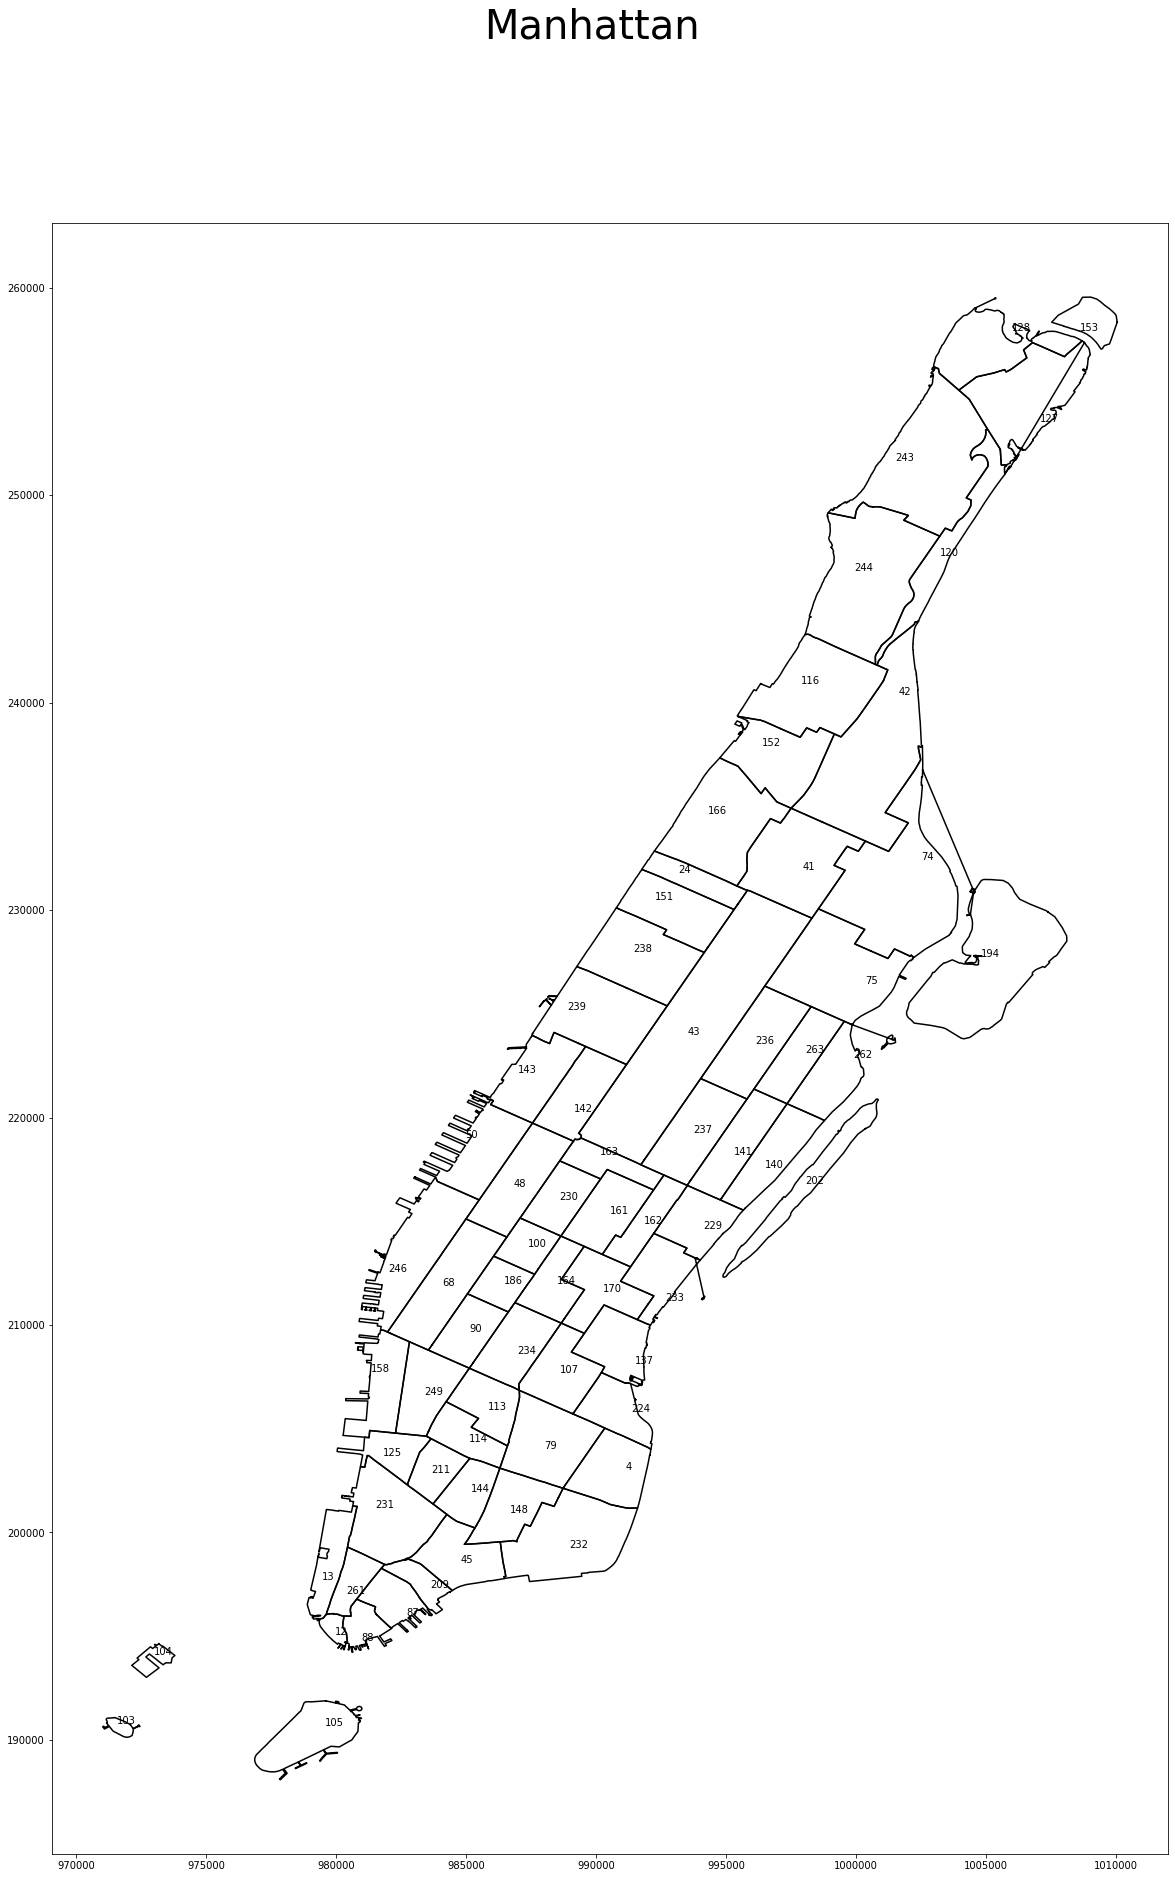

In [319]:
map_dict = {'sf':sf_nyc, 'figsize':(20,30),'title':'Manhattan', 
            'df':df_Mon_jan_2018, 'df_sf':df_sf_nyc, 'map_type':'Manhattan'}


plot_results(map_dict)

In [116]:
def plot_map(sf, x_lim = None, y_lim = None, figsize = (30,30)):
    '''
    Plot map with lim coordinates
    '''
    plt.figure(figsize = figsize)
    id=0
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x, y, 'k')
        
        if (x_lim == None) & (y_lim == None):
            x0 = np.mean(x)
            y0 = np.mean(y)
            plt.text(x0, y0, id, fontsize=10)
        id = id+1
    
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)

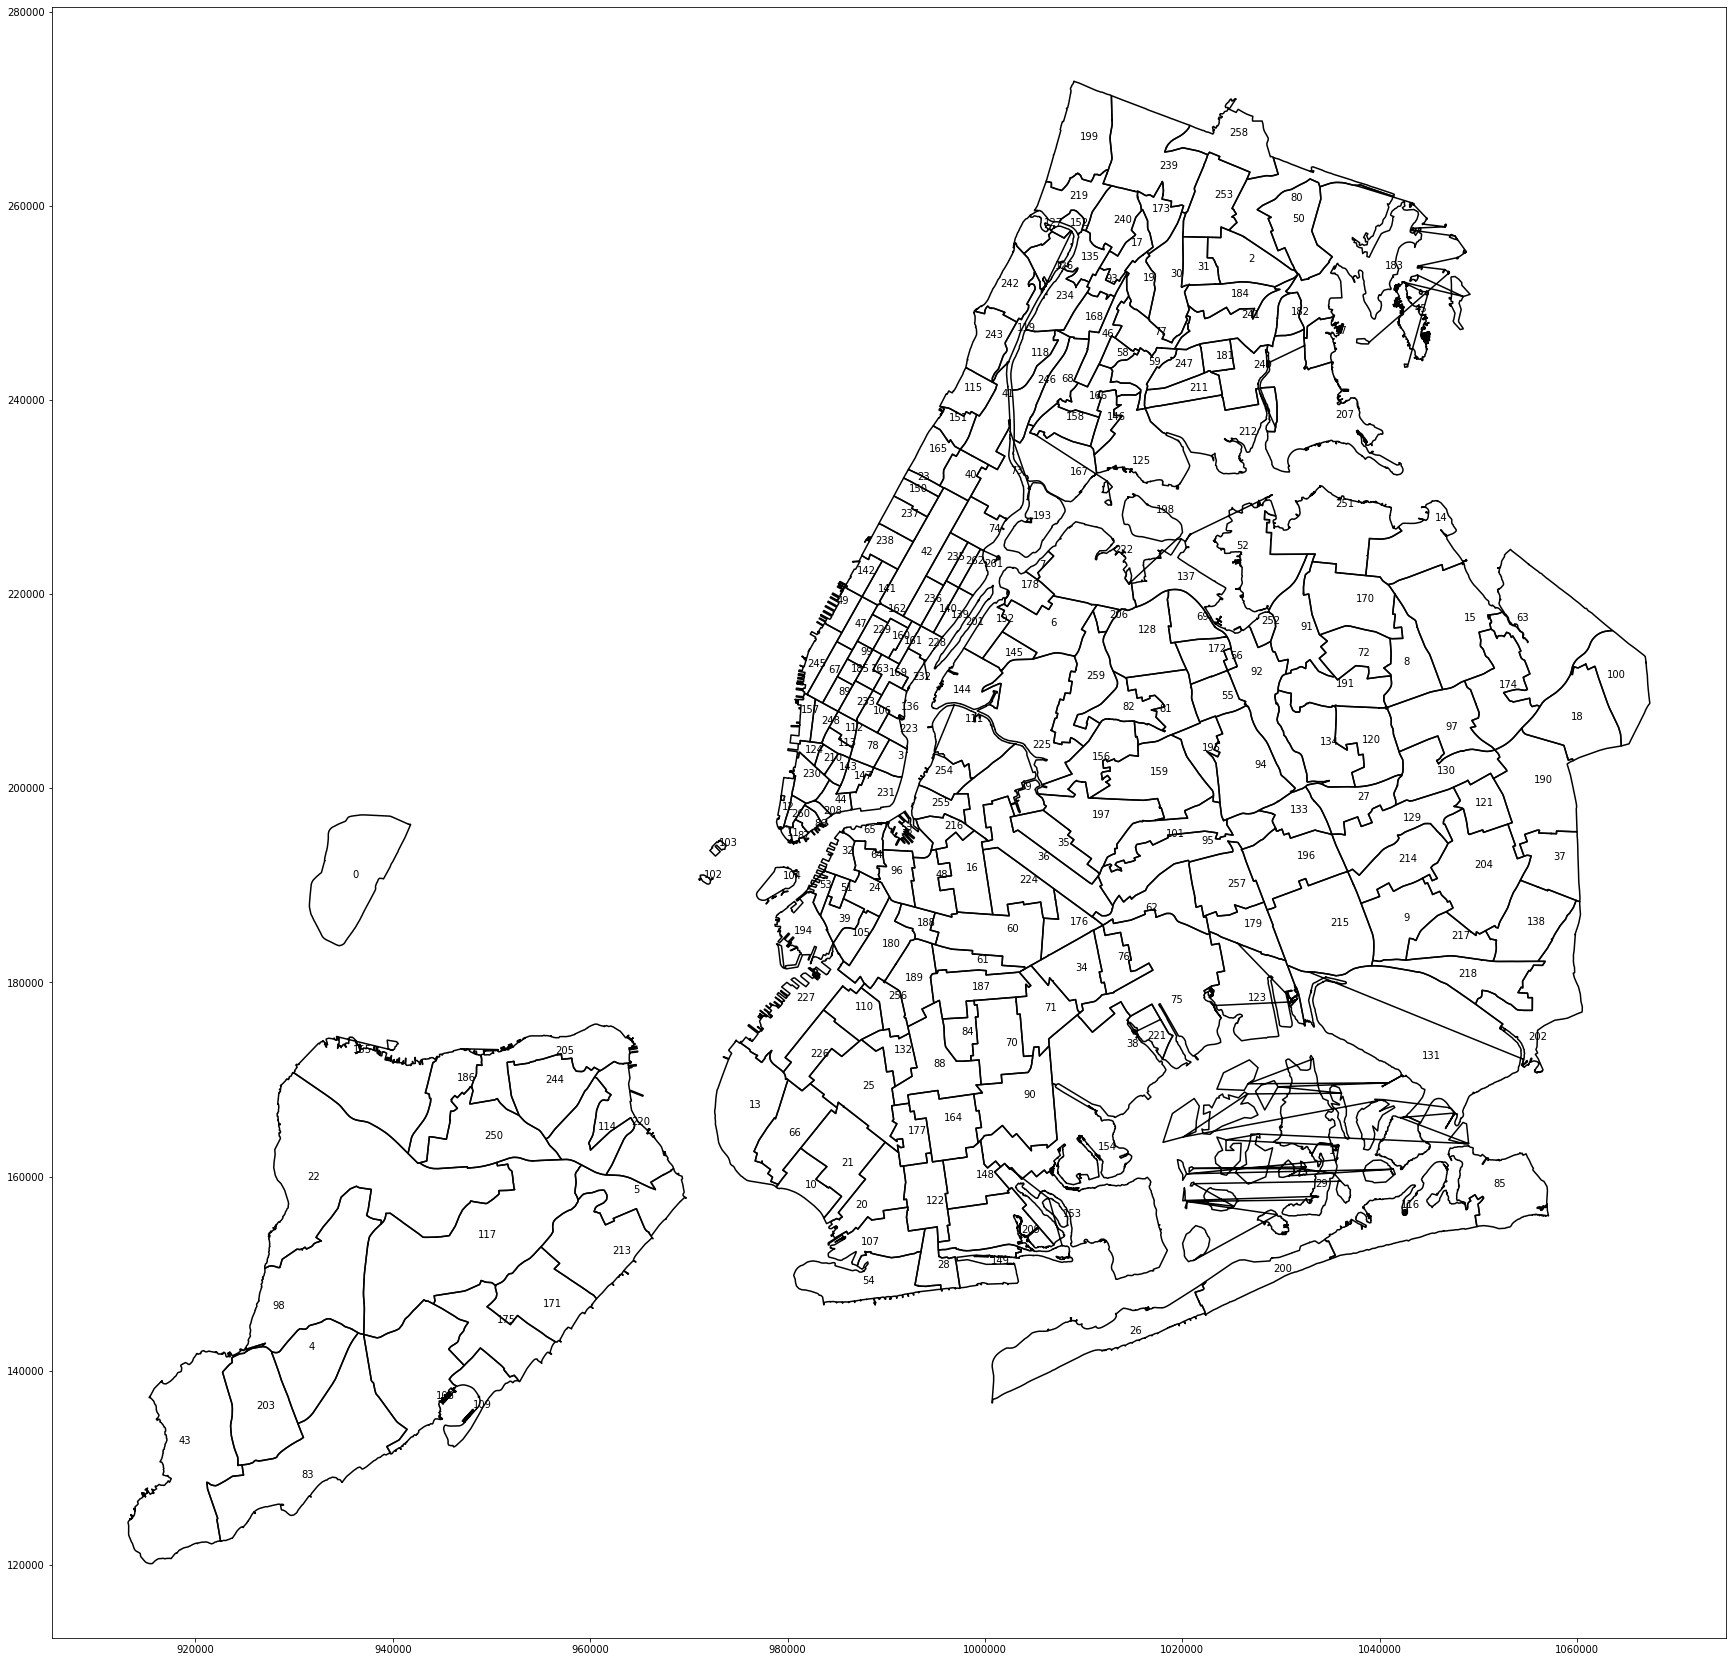

In [117]:
plot_map(sf_nyc)

In [119]:
df_sf_nyc[df_sf_nyc['OBJECTID']==43]['coords']

42    [(991852.9733769447, 217950.80729070306), (991...
Name: coords, dtype: object

In [ ]:

#Look at outliers?


Pictures for the blog post

https://www.google.com/imgres?imgurl=https%3A%2F%2Fimages.fineartamerica.com%2Fimages-medium-large-5%2Fnyc-yellow-cabs--ck-hannes-cmarits.jpg&imgrefurl=https%3A%2F%2Fpixels.com%2Ffeatured%2Fnyc-yellow-cabs--ck-hannes-cmarits.html&docid=w362TdiAvFoQ6M&tbnid=kt9sXXxu6rRpWM%3A&vet=12ahUKEwjWzveaqtzjAhXjAWMBHW7NAf44ZBAzKDMwM3oECAEQNQ..i&w=900&h=450&client=safari&bih=877&biw=1324&q=nyc%20yellow%20taxi&ved=2ahUKEwjWzveaqtzjAhXjAWMBHW7NAf44ZBAzKDMwM3oECAEQNQ&iact=mrc&uact=8

https://www.google.com/imgres?imgurl=https%3A%2F%2Fcdn.vox-cdn.com%2Fthumbor%2Fw_4S1JHSyjLoTrgzyyYyFP1PVZo%3D%2F0x0%3A2479x1653%2F1200x800%2Ffilters%3Afocal(1042x629%3A1438x1025)%2Fcdn.vox-cdn.com%2Fuploads%2Fchorus_image%2Fimage%2F60025757%2Fshutterstock_498615637.0.jpg&imgrefurl=https%3A%2F%2Fny.curbed.com%2F2018%2F6%2F11%2F17450366%2Fnyc-taxi-medallions-bankruptcy-auction&docid=bVXF7JiWLLYdmM&tbnid=XEaSCOYrfMBVpM%3A&vet=12ahUKEwjWzveaqtzjAhXjAWMBHW7NAf44ZBAzKBcwF3oECAEQGQ..i&w=1200&h=800&client=safari&bih=877&biw=1324&q=nyc%20yellow%20taxi&ved=2ahUKEwjWzveaqtzjAhXjAWMBHW7NAf44ZBAzKBcwF3oECAEQGQ&iact=mrc&uact=8

https://www.google.com/imgres?imgurl=https%3A%2F%2Fmedia.timeout.com%2Fimages%2F103898485%2F630%2F472%2Fimage.jpg&imgrefurl=https%3A%2F%2Fwww.timeout.com%2Fnewyork%2Fthings-to-do%2Fbest-transportation-apps-for-new-yorkers&docid=FTZypUMzUyB2gM&tbnid=7B9lem8HGM__rM%3A&vet=12ahUKEwjWzveaqtzjAhXjAWMBHW7NAf44ZBAzKBkwGXoECAEQGw..i&w=630&h=472&client=safari&bih=877&biw=1324&q=nyc%20yellow%20taxi&ved=2ahUKEwjWzveaqtzjAhXjAWMBHW7NAf44ZBAzKBkwGXoECAEQGw&iact=mrc&uact=8

https://www.google.com/imgres?imgurl=http%3A%2F%2Fwww.gmu.daddlr.com%2Fwp-content%2Fuploads%2F2016%2F03%2Fnyc_cab.jpg&imgrefurl=http%3A%2F%2Fwww.gmu.daddlr.com%2Fnyc-yellow-cab%2F&docid=Z2dvl8KUjxNEdM&tbnid=6NWXf15bPdsdKM%3A&vet=12ahUKEwjWzveaqtzjAhXjAWMBHW7NAf44ZBAzKA8wD3oECAEQEQ..i&w=1000&h=667&client=safari&bih=877&biw=1324&q=nyc%20yellow%20taxi&ved=2ahUKEwjWzveaqtzjAhXjAWMBHW7NAf44ZBAzKA8wD3oECAEQEQ&iact=mrc&uact=8

https://www.google.com/imgres?imgurl=http%3A%2F%2Fupload.wikimedia.org%2Fwikipedia%2Fcommons%2Fd%2Fd3%2FYellow_Cabs_in_New_York.JPG&imgrefurl=http%3A%2F%2Fwww.bkmag.com%2F2014%2F03%2F19%2Fnyc-taxi-launches-a-new-livery-cab-and-car-service-locator%2F&docid=lpsqhToXTGDLaM&tbnid=W-HYJdt8KBRxrM%3A&vet=10ahUKEwidypr6qdzjAhXBiFwKHWIEDqkQMwiSASgjMCM..i&w=3072&h=2048&client=safari&bih=877&biw=1324&q=nyc%20yellow%20taxi&ved=0ahUKEwidypr6qdzjAhXBiFwKHWIEDqkQMwiSASgjMCM&iact=mrc&uact=8



Ideas of blog post title
This is why
X facts that will make you
Do you know how to make the most of your taxi ride?



Objective : 
- use the NYC taxi rides huge database to make sense out of so much data
- come up with a simple presentation of the insights this data brings on the life of the city

We will look at three different axis in this analysis:
- the points of interest in NYC (from and where to trends, over time and for specific dates)
    - Where are people going on weekdays vs weekends?
    - Is it much different when it is a main holiday (Christmas, New Year's Eve, National Day, Valentines Day)?
    - Did it change overtime for the past 10 years? Or the centers of interest remained?
    - What about trip duration? Do people take taxis for short or long trips? 
    - In the context of growing awareness of the importance of using public transportation, do the habits of passengers to take a taxi match the availability of a public transportation alternative? This is to say, do people take a taxi when they have no other simple option using public transportation? Is it related to the number of people that travel? 
- the economic point of view (correlation of location and fare amount, trip type evolution and location repartion, most profitable insights)
    - What is the percentage of time a taxi driver is busy? 
    - In which areas would it be easier for the taxi driver to maximise profit (short ride with high rate)?
    - Relationship between payment type, tip and location of pickup/dropoff?
    - Evolution of the trip type 'app vs street-hail' in the past 10 years and repartition based on the location in the city


What are the most frequent itineraries in NYC? i.e. where are people taking taxis and heading to, what are the strongest links between area of NYC?
What are the main traffic patterns - itineraries, number of passengers, payment types
    - weekdays vs weekends
    - for specific holidays
    - trends over the years?

How do people get into the taxi? Evolution of the trip type 'app vs street-hail' in the past 10 years and repartition based on the location in the city

When should you take the taxi (and where should taxi drivers go to optimise money gain)? (taxi idle times, availability of alternative waiting time for public transportation, average trip duration)

Is this the beginning of the end for the yellow taxis? An overview of the impact of FHV on the traffic and business of the iconic yellow taxis.